
# install needed dependecy


In [1]:
pip install pmdarima


# Chapter 1: AutoRegressive Integrated Moving Average (ARIMA)

Prepared by: Benjur Emmanuel L. Borja and Maria Eloisa M. Ventura

In this notebook, we will introduce our first approach to time-series forecasting which is **ARIMA** or AutoRegressive Integrated Moving Average. This notebook will discuss:
1. Definition and Formulation of ARIMA models
2. Model Parameters (p, d, and q) and Special Cases of ARIMA models
3. Model Statistics and How to Interpret
4. Implementation and Forecasting using ARIMA

In [2]:
#Import required Libraries
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from pandas import read_csv
import multiprocessing as mp
import pmdarima as pm
### Just to remove warnings to prettify the notebook.
import warnings
warnings.filterwarnings("ignore")

## Introduction to ARIMA

ARIMA, or AutoRegressive Integrated Moving Average, is a set of models that explains a time series using its own previous values given by the lags (**A**uto**R**egressive) and lagged errors (**M**oving **A**verage) while considering stationarity corrected by differencing (oppossite of **I**ntegration.) In other words, ARIMA assumes that the time series is described by autocorrelations in the data rather than trends and seasonality. In these context, we define trends and seasonality as the following:
- **Trend**: A time series has a trend if there is a overlying long term increase or decrease in the data, which is not necessarily linear.
- **Seasonality**: A time series data has seasonality when it is affected by seasonal factors such as the time of the year or the day of the week. The seasonality of data is apparent as there is a fixed frequency of pattern occurence.

### Model Components

## Model parameters *p, d, and q* and Special Cases

Before we discuss how we determine p, d, and q that are best to represent a time series, let's first take a look at special cases of ARIMA models that should help us illustrate the formulation of the ARIMA equation.

**Case 1: ARIMA(p,0,0) = autoregressive model**: if the series is stationary and autocorrelated, perhaps it can be predicted as a multiple of its own previous value, plus a constant.

The forecasting equation for ARIMA(1,0,0) is:

\begin{equation}
X_{t}  =  \mu  + \alpha _{1}X_{t-1}
\end{equation}

while ARIMA(2,0,0)

\begin{equation}
X_{t}  =  \mu  + \alpha _{1}X_{t-1} +  \alpha _{2}X_{t-2}
\end{equation}

or in general ARIMA(p,0,0)

\begin{equation}
X_{t}  =  \mu  + \alpha _{1}X_{t-1} +  \alpha _{2}X_{t-2} \dots + \alpha _{p}X_{t-p}
\end{equation}

**Case 2: ARIMA(0,0,q) = moving average model**: if the series is stationary but is correlated to the errors of previous values, we can regress using the past forecast errors.

The forecasting equation for this is ARIMA(0,0,1) given by:

\begin{equation}
X_{t} = \varepsilon _{t}+\theta_{1}\varepsilon _{t-1}
\end{equation}

or in simillar fashion to p, this can be generalized to ARIMA(0,0,q):

\begin{equation}
X_{t} = \varepsilon _{t}+\theta_{1}\varepsilon _{t-1}+\cdots +\theta _{q}\varepsilon _{t-q}
\end{equation}

where $\theta_{q}$ is the coefficient at time $t-q$ of the residual $\varepsilon _{t-q}$.


**Case 3: ARIMA(0,1,0) = Random Walk**: if the series is non-stationary then the simplest model that we can use is a random walk model, which is given by:

\begin{equation}
X_{t}  =  \mu  + X_{t-1}
\end{equation}

### Determining *p*, *d*, and *q*

We need to explicitly indicate p, d, and q when implementing ARIMA models. Selecting appropriate p, d, and q can be difficult but there are several methods of automating this process. For example, we can use grid search in python to scan through different values and check which model would be optimal (will be discussed later.) R uses the auto.arima() function to do this automatically. For our case, we will look at the Augmented-Dickey Fuller Test (ADF), AutoCorrelation Function (ACF), and Partial Autocorrelation Function (PACF) to determine our model parameters.

#### Finding the order differencing *d*

As stated before, ARIMA models are assumed to be stationary. Implementing differencing may induce stationarity for various time series. The quickest way

to determine *d* for our models is to difference and simply run ADF to check for stationarity. We can also look at the PACF and ACF to see if our time series is stationary after *d* differencing.

To illustrate, let's take a look at the following example:

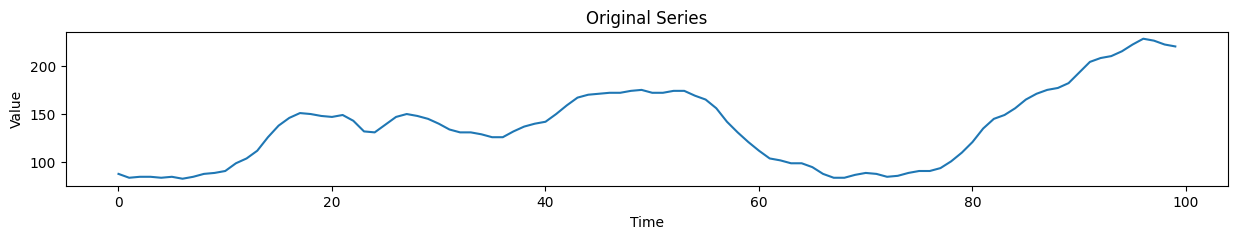

In [3]:
# We're using a sample data from https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv
# Import data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)
plt.figure(figsize=(15, 2))
plt.plot(df)
plt.title('Original Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

# Dickey-Fuller Test

The Dickey-Fuller test is a statistical test used to determine whether a unit root is present in an autoregressive model. The presence of a unit root indicates that the time series is non-stationary.

## Basic Concept

The basic form of the Dickey-Fuller test can be described with the following autoregressive model of order 1 (AR(1)):

\begin{equation}
Y_t = \mathcal{M} + \phi_1 Y_{t-1} + \epsilon_t
\end{equation}

### Hypotheses

The null and alternative hypotheses for the test are:
- \begin{equation}( H_0: \phi_1 = 1 )\end{equation} (The time series has a unit root and is non-stationary)
- \begin{equation}( H_1: \phi_1 < 1 )\end{equation} (The time series does not have a unit root and is stationary)

## Test Procedure

Rewriting the AR(1) model by subtracting \begin{equation}( Y_{t-1} )\end{equation} from both sides:

\begin{equation}
Y_t - Y_{t-1} = \mathcal{M} + (\phi_1 - 1) Y_{t-1} + \epsilon_t
\end{equation}

Let \begin{equation} ( \delta = \phi_1 - 1 ):\end{equation}

\begin{equation}
\Delta Y_t = \mathcal{M}' + \delta Y_{t-1} + \epsilon_t
\end{equation}

where - \begin{equation}( \Delta Y_t = Y_t - Y_{t-1} ) and\ ( \mathcal{M}' ) is\ a\ constant\end{equation}.

### Test Statistic

The test statistic for the Dickey-Fuller test is calculated as:

\begin{equation}
t_{\hat{\delta}} = \frac{\hat{\delta}}{se(\hat{\delta})}
\end{equation}

where \begin{equation} ( \hat{\delta} ) is\ the\ estimated\ value\ of\ ( \delta ) and\ ( se(\hat{\delta}) ) is\ the\ standard\ error\ of\ ( \hat{\delta} )\end{equation}.

### Decision Rule

Compare the test statistic \( t_{\hat{\delta}} \) with the critical value from the Dickey-Fuller distribution:
- \begin{equation}If ( t_{\hat{\delta}} < DF_{critical} ), reject ( H_0 ) \end{equation}.
- \begin{equation}If ( t_{\hat{\delta}} > DF_{critical} ), do\ not\ reject ( H_0 )\end{equation}.

By following the steps outlined above, you can conduct the Dickey-Fuller test and the Augmented Dickey-Fuller test to determine whether a time series is stationary or has a unit root.


Initial eyeballing shows that there is a trend for this time series and is non-stationary. Checking using ADF:

- result[0]: The ADF test statistic.
- result[1]: The p-value of the test.
- result[2]: The number of lags used in the test.
- result[3]: The number of observations used in the test.
- result[4]: A dictionary containing the critical values for different significance levels (1%, 5%, 10%).

In [4]:
result = adfuller(df.value.dropna())
critical_values = result[4]

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in critical_values.items():
    print(f'   {key}: {value}')

ADF Statistic: -2.464240
p-value: 0.124419
   1%: -3.5003788874873405
   5%: -2.8921519665075235
   10%: -2.5830997960069446


The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary. For our example, we fail to reject the null hypothesis.

Next we difference our time series and check the results of the ADF test. We will also look at the ACF.

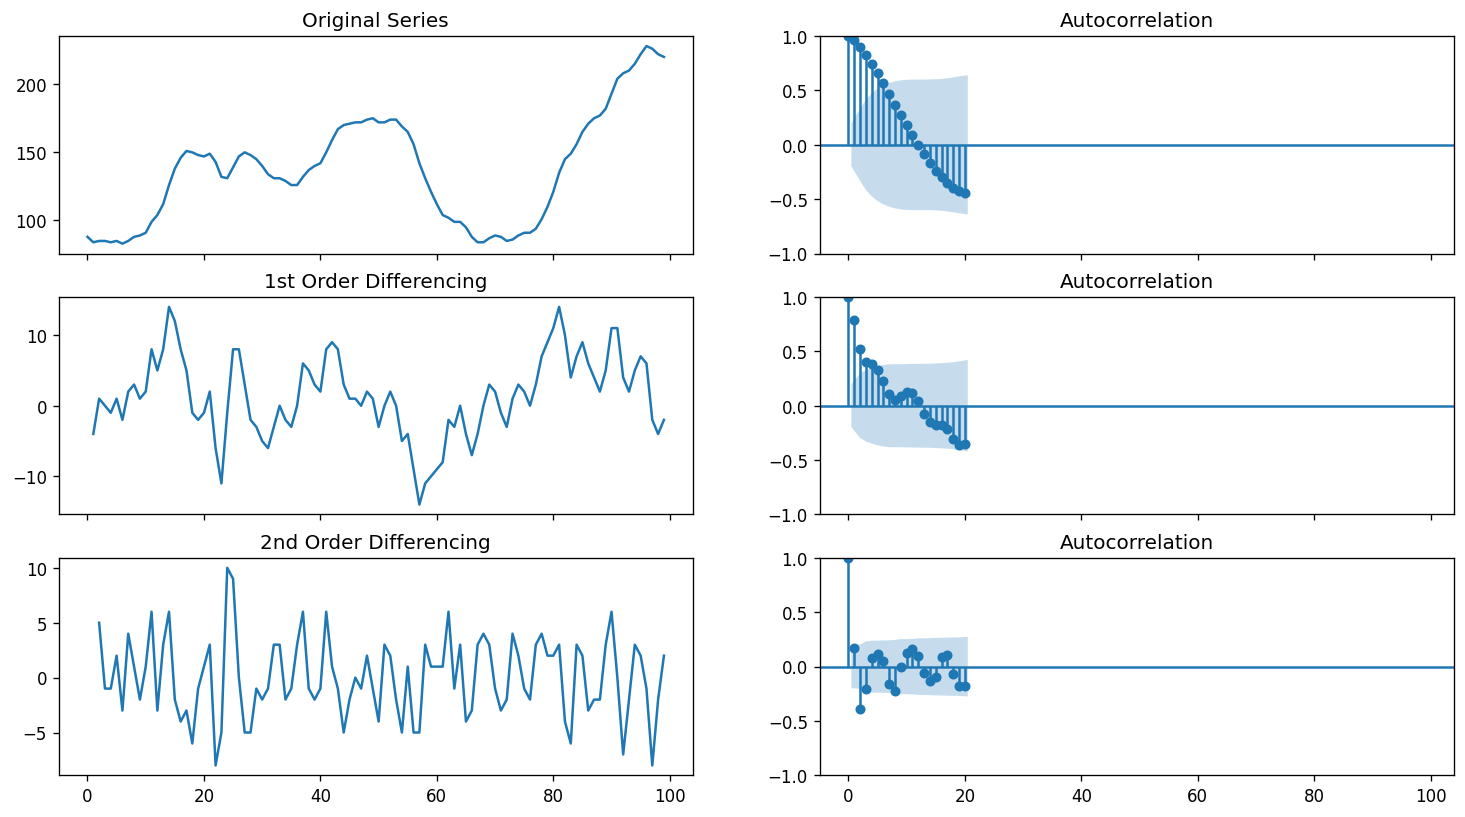

ADF Statistic for 1st Order Differencing
ADF Statistic: -2.722238
p-value: 0.070268
Critical Values:
	1%: -3.500
	5%: -2.892
	10%: -2.583

 ADF Statistic for 2nd Order Differencing
ADF Statistic: -9.929762
p-value: 0.000000
Critical Values:
	1%: -3.500
	5%: -2.892
	10%: -2.583


In [5]:
plt.rcParams.update({'figure.figsize':(15,8), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

print('ADF Statistic for 1st Order Differencing')
result = adfuller(df.value.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

print('\n ADF Statistic for 2nd Order Differencing')
result = adfuller(df.value.diff().diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Given the results of our ACF and ADF, we can see that our time series reachees stationarity after two orders of differencing. However, the ACF of the 2nd order differencing goes into the negative zone fairly quick. This can indicates that the series might have been over differenced. It is now up to us if we want consider the first or second order differencing for our ARIMA models.

# Difference Between PACF and ACF

In time series analysis, the Autocorrelation Function (ACF) and the Partial Autocorrelation Function (PACF) are fundamental tools used to understand the relationships within a time series. Here’s a breakdown of each:

<p align="center">
  <img src="https://miro.medium.com/v2/resize:fit:1358/1*SlmQlOYrwVyngsH5bh0iCA.jpeg" alt="ACF vs PACF" width="45%" style="display:inline-block;"/>
  <img src="https://i0.wp.com/varshasaini.in/wp-content/uploads/2022/12/ACF-PACF-1.png?resize=768%2C432&ssl=1" alt="ACF vs PACF" width="45%" style="display:inline-block;"/>
</p>

## Autocorrelation Function (ACF)

### Definition
- **ACF** measures the correlation between observations of a time series separated by \( k \) time units. It is used to identify the degree of similarity between the time series and a lagged version of itself.

### Purpose
- **ACF** helps in identifying the presence of autocorrelation in a time series and is particularly useful in determining the **q** parameter in ARIMA models (Moving Average part).


## Partial Autocorrelation Function (PACF)

### Definition
- **PACF** measures the correlation between observations of a time series separated by \( k \) time units after removing the effects of shorter lags. It provides a clearer picture of the direct relationship between observations at lag \( k \), controlling for the influences of lags shorter than \( k \).

### Purpose
- **PACF** helps in identifying the **p** parameter in ARIMA models (Autoregressive part). It is useful for determining the order of the autoregressive process.


## Summary of Differences

- **ACF** measures total correlation including both direct and indirect effects from all previous lags.
- **PACF** measures only the direct correlation at a specific lag, controlling for the effects of shorter lags.



#### Finding the order of the AutoRegressive term *p*

As we have discussed previously, we can look at the PACF plot to determine the lag for our AR terms. Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series. That way, we will know if that lag is needed in the AR term or not.

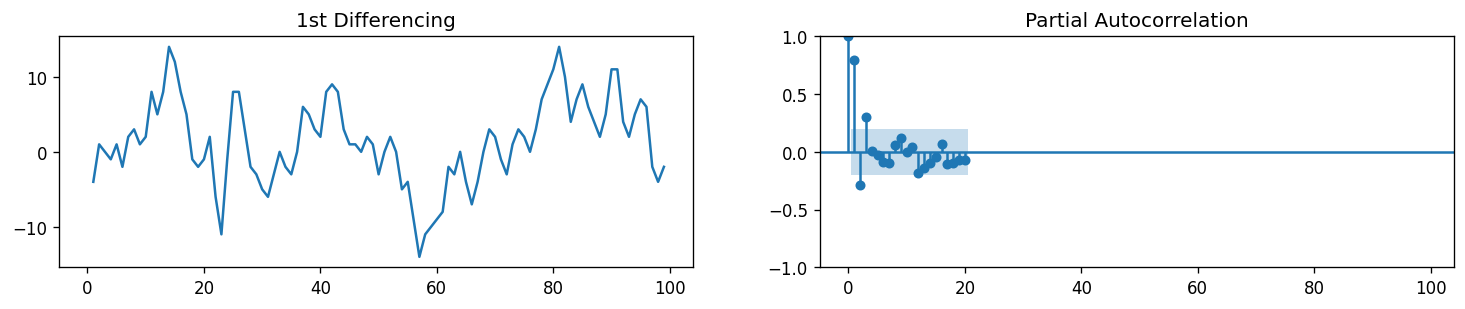

In [6]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(15,2.5), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1])

plt.show()

Immediately, we can observe that our PACF returns sigificance at Lag 1 and Lag 2, meaning it crosses the significance limit (blue region). We can also observe significance at higher order terms but note that given the amount of lag that we are testing, it is statistically probable to see random spikes in our PACF and ACF plots. *Although this can also be attributed to Seasonality which will be tackled separately.*

With this, we can now decide to use $p = 2$ for our ARIMA model.

#### Finding the order of the Moving Average term *q*

Simillar to how we determined $p$, we will now look at the ACF to determine the $q$ terms to be considered for our MA. The ACF tells how many MA terms are required to remove any autocorrelation in the stationary series.

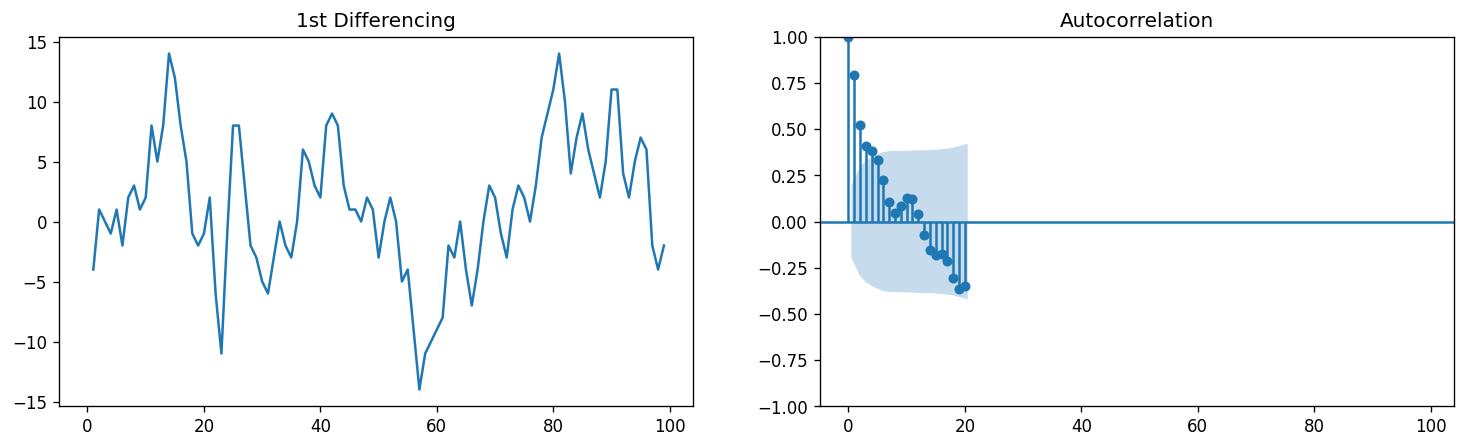

In [7]:
# ACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(15,4), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1))
plot_acf(df.value.diff().dropna(), ax=axes[1])

plt.show()

Our results for the ACF is not as apparent compared to our PCF. We can observed several ACF terms that is above our significance level. This may be  attritbuted to the fact that our model has a weak stationarity. This may also be caused by the fact that our time series is not perfectly MA and is an ARIMA model. For now, let's consider $q = 3$.

## Building the ARIMA model
Now that we’ve determined the values of p, d and q, we have everything needed to fit the ARIMA model. Let's implement using this dataset first before we move on to a deeper look at the implementation of ARIMA in the next section. Let’s use the ARIMA() implementation in statsmodels package. As computed, we will use ARIMA(2,1,3):

In [9]:

model = ARIMA(df['value'], order=(2, 1, 3))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -251.887
Date:                Sun, 21 Jul 2024   AIC                            515.774
Time:                        13:47:49   BIC                            531.345
Sample:                             0   HQIC                           522.074
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5641      0.505      1.118      0.264      -0.425       1.553
ar.L2          0.2410      0.345      0.698      0.485      -0.435       0.917
ma.L1          0.6227      0.504      1.236      0.2

There's quite a bit of information to unpack from the summary. Generally, we are interested in the Akaike’s Information Criterion (AIC), coefficients of our AR and MA terms (coef_), and the p-values of the terms (P>|z|). We need the p-values to be less than 0.05 to be significant, which means that our model failed to reach significance for the AR and MA terms. Let's try to be conservative and use small values for p and d, i.e. ARIMA(1,1,1), as given by the p-values of AR1 and MA1 in our results.

In [10]:
model = ARIMA(df.value, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -254.150
Date:                Sun, 21 Jul 2024   AIC                            514.300
Time:                        13:48:37   BIC                            522.086
Sample:                             0   HQIC                           517.450
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6504      0.090      7.258      0.000       0.475       0.826
ma.L1          0.5256      0.088      5.994      0.000       0.354       0.697
sigma2         9.7934      1.405      6.970      0.0

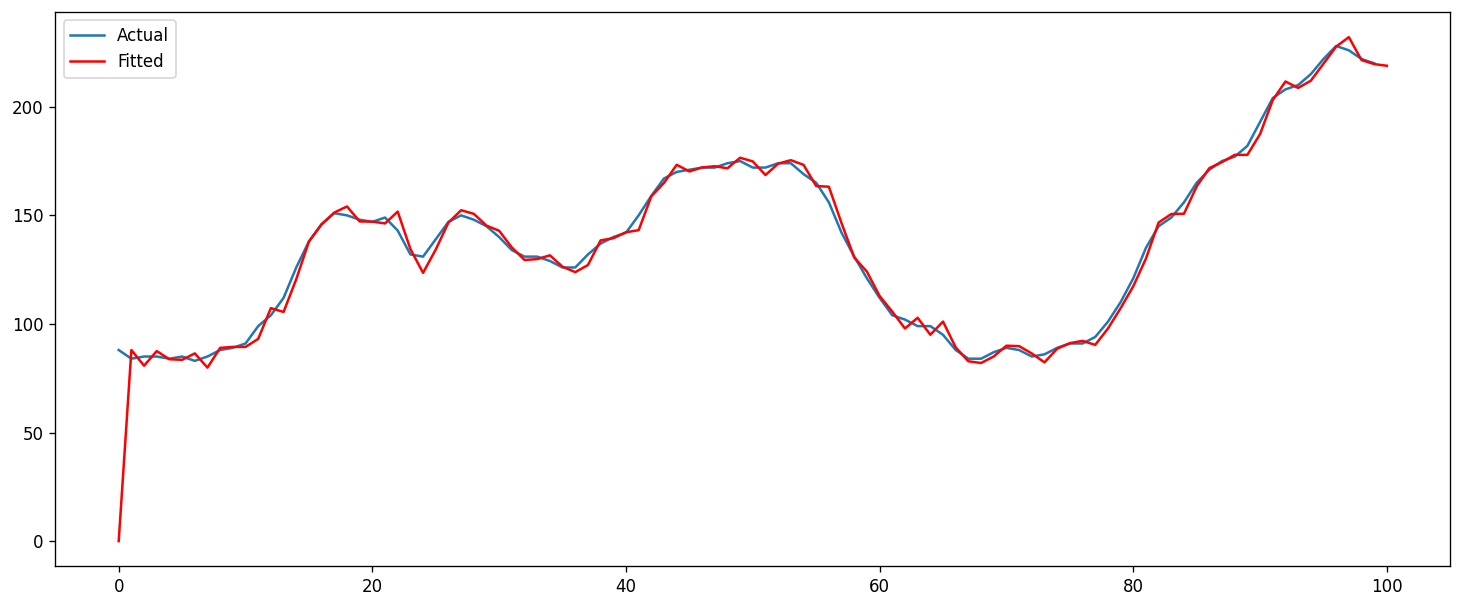

In [11]:
# Make predictions
start = 0
end = 100
predictions = model_fit.predict(start=start, end=end, dynamic=False)

# Plot actual vs predicted
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(df.index, df['value'], label='Actual')
ax.plot(predictions.index, predictions, label='Fitted', color='red')

plt.legend()
plt.show()

In [12]:
# Fit auto_arima model
model = pm.auto_arima(df['value'], seasonal=False, stepwise=True)

# Extract differencing order
p = model.order[0]  # ARIMA(p,d,q)

d = model.order[1]  # ARIMA(p,d,q)
q = model.order[2]  # ARIMA(p,d,q)
# Print all parameters
print(f"Optimal ARIMA model parameters:")
print(f"p (autoregressive order): {p}")
print(f"d (differencing order): {d}")
print(f"q (moving average order): {q}")


print(f"Optimal differencing order: {d}")

Optimal ARIMA model parameters:
p (autoregressive order): 2
d (differencing order): 0
q (moving average order): 2
Optimal differencing order: 0


In [13]:
model = ARIMA(df.value, order=(2,0,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -256.784
Date:                Sun, 21 Jul 2024   AIC                            525.569
Time:                        13:50:37   BIC                            541.200
Sample:                             0   HQIC                           531.895
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        138.0775     10.595     13.032      0.000     117.311     158.844
ar.L1          1.9281      0.051     37.513      0.000       1.827       2.029
ar.L2         -0.9452      0.052    -18.291      0.0

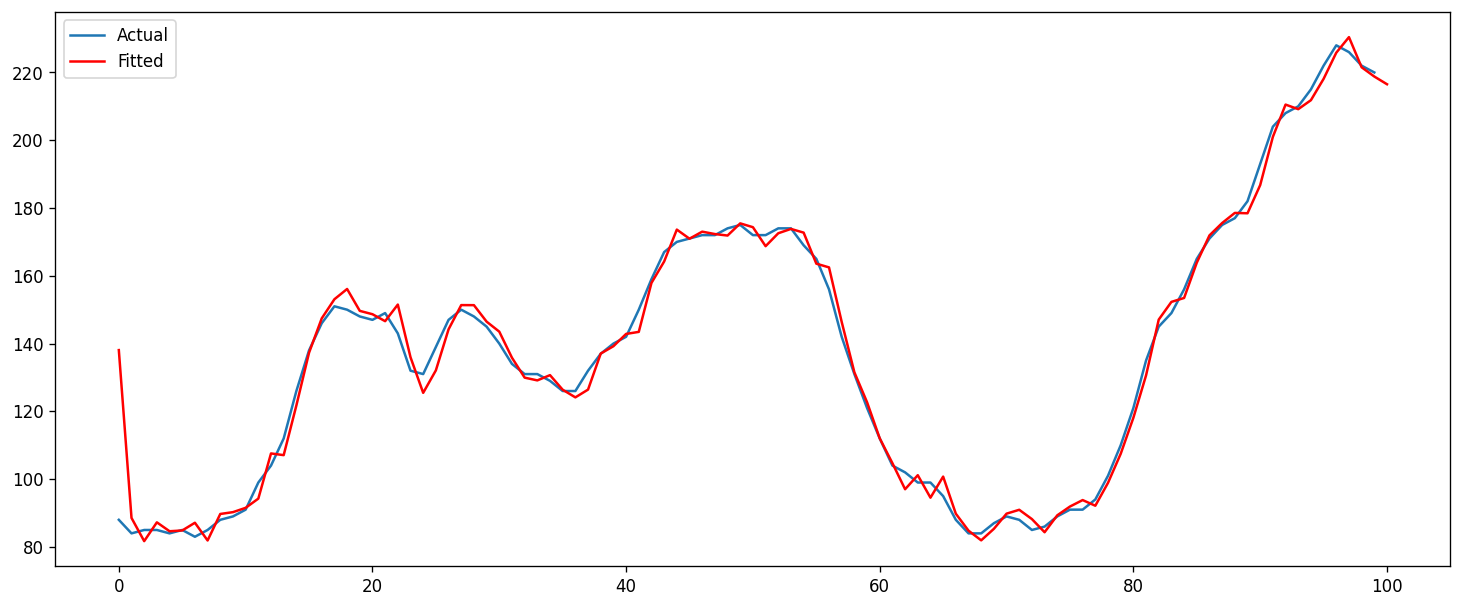

In [14]:
# Make predictions
start = 0
end = 100
predictions = model_fit.predict(start=start, end=end, dynamic=False)

# Plot actual vs predicted
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(df.index, df['value'], label='Actual')
ax.plot(predictions.index, predictions, label='Fitted', color='red')

plt.legend()
plt.show()


## References

The contents of this notebook is compiled from the following sources:
- https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
- https://otexts.com/fpp2/arima.html
- https://people.duke.edu/~rnau/411arim.htm
- https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/
- https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/
- https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c
- https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average
- C.Monterola, *"Notebook 10 Time Series Forecasting Method --- ARIMA MSDS2021"*
- Hyndman, R. J., & Khandakar, Y. (2008). Automatic time series forecasting: The forecast package for R. Journal of Statistical Software, 27(1), 1–22. https://doi.org/10.18637/jss.v027.i03